In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Exercise 9.

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_full = x_train_full / 255
x_test = x_test / 255

x_train, x_valid = x_train_full[5000:], x_train_full[:5000]
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [4]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(learning_rate=1.0), 
                     metrics=[rounded_accuracy])

In [5]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [6]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [7]:
denoising_ae.fit(x_train, x_train, epochs=10, 
                 validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1981 - rounded_accuracy: 0.9103 - val_loss: 0.1495 - val_rounded_accuracy: 0.9381
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1410 - rounded_accuracy: 0.9428 - val_loss: 0.1278 - val_rounded_accuracy: 0.9501
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1288 - rounded_accuracy: 0.9495 - val_loss: 0.1203 - val_rounded_accuracy: 0.9546
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1227 - rounded_accuracy: 0.9529 - val_loss: 0.1149 - val_rounded_accuracy: 0.9578
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1187 - rounded_accuracy: 0.9552 - val_loss: 0.1119 - val_rounded_accuracy: 0.9594
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1162 - rounded_accuracy: 0.9565 - val_loss: 0.1099 - val_rounded_accuracy: 0.9606
Epoch 7/10
1719/1719 [==================

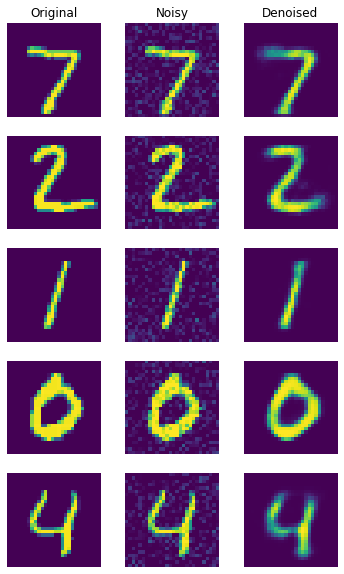

In [8]:
n_images = 5
new_images = x_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 28, 28) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [9]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_valid_one_hot = to_categorical(y_valid)
y_test_one_hot = to_categorical(y_test)

x_train_small, y_train_small = x_train[:500], y_train_one_hot[:500]

In [10]:
cls = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(10, activation='softmax'),
])

In [11]:
cls.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [12]:
for layer in denoising_encoder.layers:
    if layer.name == 'dense':
        weights = layer.get_weights()
        
for layer in cls.layers:
    if layer.name == 'dense_4':
        layer.set_weights(weights)

In [13]:
cls.get_weights()[0]

array([[-0.00527395, -0.06471772, -0.0214266 , ..., -0.0615193 ,
         0.03561438,  0.01336329],
       [ 0.03959517, -0.06403989,  0.01336462, ...,  0.06326349,
        -0.02782636, -0.03194641],
       [ 0.02940785, -0.01331449,  0.02585114, ...,  0.05418384,
        -0.03200356,  0.03616562],
       ...,
       [ 0.06627277, -0.03255405, -0.00811658, ..., -0.00042804,
        -0.02126018, -0.05820848],
       [-0.01002369,  0.01237492, -0.01288215, ..., -0.01495094,
        -0.0651235 , -0.07172707],
       [-0.0094409 ,  0.05525199, -0.01781904, ..., -0.01596308,
         0.00172837, -0.05718918]], dtype=float32)

In [14]:
denoising_encoder.get_weights()[0]

array([[-0.00527395, -0.06471772, -0.0214266 , ..., -0.0615193 ,
         0.03561438,  0.01336329],
       [ 0.03959517, -0.06403989,  0.01336462, ...,  0.06326349,
        -0.02782636, -0.03194641],
       [ 0.02940785, -0.01331449,  0.02585114, ...,  0.05418384,
        -0.03200356,  0.03616562],
       ...,
       [ 0.06627277, -0.03255405, -0.00811658, ..., -0.00042804,
        -0.02126018, -0.05820848],
       [-0.01002369,  0.01237492, -0.01288215, ..., -0.01495094,
        -0.0651235 , -0.07172707],
       [-0.0094409 ,  0.05525199, -0.01781904, ..., -0.01596308,
         0.00172837, -0.05718918]], dtype=float32)

In [15]:
for layer in cls.layers:
    if layer.name != 'dense_5':
        layer.trainable = False

In [16]:
cls.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adam(), 
            metrics=['acc'])

cls.fit(x_train_small, y_train_small, epochs=15)

Epoch 1/15
16/16 [==============================] - 0s 3ms/step - loss: 3.1280 - acc: 0.1260
Epoch 2/15
16/16 [==============================] - 0s 3ms/step - loss: 2.4144 - acc: 0.2480
Epoch 3/15
16/16 [==============================] - 0s 3ms/step - loss: 2.0849 - acc: 0.3360
Epoch 4/15
16/16 [==============================] - 0s 3ms/step - loss: 1.7503 - acc: 0.4240
Epoch 5/15
16/16 [==============================] - 0s 3ms/step - loss: 1.5444 - acc: 0.5120
Epoch 6/15
16/16 [==============================] - 0s 3ms/step - loss: 1.3596 - acc: 0.5480
Epoch 7/15
16/16 [==============================] - 0s 3ms/step - loss: 1.2056 - acc: 0.6140
Epoch 8/15
16/16 [==============================] - 0s 3ms/step - loss: 1.0953 - acc: 0.6380
Epoch 9/15
16/16 [==============================] - 0s 3ms/step - loss: 0.9772 - acc: 0.7000
Epoch 10/15
16/16 [==============================] - 0s 3ms/step - loss: 0.8885 - acc: 0.7440
Epoch 11/15
16/16 [==============================] - 0s 3ms/step - lo

In [17]:
for layer in cls.layers:
    layer.trainable = True

In [18]:
cls.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adam(), 
            metrics=['acc'])

cls.fit(x_train_small, y_train_small, epochs=15)

Epoch 1/15
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - acc: 0.8160
Epoch 2/15
16/16 [==============================] - 0s 3ms/step - loss: 0.4474 - acc: 0.8800
Epoch 3/15
16/16 [==============================] - 0s 3ms/step - loss: 0.3514 - acc: 0.9320
Epoch 4/15
16/16 [==============================] - 0s 3ms/step - loss: 0.2855 - acc: 0.9360
Epoch 5/15
16/16 [==============================] - 0s 3ms/step - loss: 0.2578 - acc: 0.9460
Epoch 6/15
16/16 [==============================] - 0s 3ms/step - loss: 0.2253 - acc: 0.9480
Epoch 7/15
16/16 [==============================] - 0s 3ms/step - loss: 0.2053 - acc: 0.9660
Epoch 8/15
16/16 [==============================] - 0s 3ms/step - loss: 0.1784 - acc: 0.9640
Epoch 9/15
16/16 [==============================] - 0s 3ms/step - loss: 0.1552 - acc: 0.9680
Epoch 10/15
16/16 [==============================] - 0s 3ms/step - loss: 0.1362 - acc: 0.9760
Epoch 11/15
16/16 [==============================] - 0s 3ms/step - lo

In [19]:
cls.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 1s 2ms/step - loss: 0.4869 - acc: 0.8570


[0.4869116246700287, 0.8569999933242798]

In [20]:
cls_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

cls_2.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adam(), 
            metrics=['acc'])

cls_2.fit(x_train_small, y_train_small, epochs=30)

Epoch 1/30
16/16 [==============================] - 0s 3ms/step - loss: 1.7807 - acc: 0.4420
Epoch 2/30
16/16 [==============================] - 0s 3ms/step - loss: 0.8662 - acc: 0.7580
Epoch 3/30
16/16 [==============================] - 0s 3ms/step - loss: 0.5813 - acc: 0.8500
Epoch 4/30
16/16 [==============================] - 0s 4ms/step - loss: 0.4514 - acc: 0.8920
Epoch 5/30
16/16 [==============================] - 0s 4ms/step - loss: 0.3940 - acc: 0.8940
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.3524 - acc: 0.9180
Epoch 7/30
16/16 [==============================] - 0s 3ms/step - loss: 0.3146 - acc: 0.9260
Epoch 8/30
16/16 [==============================] - 0s 3ms/step - loss: 0.2456 - acc: 0.9540
Epoch 9/30
16/16 [==============================] - 0s 3ms/step - loss: 0.2339 - acc: 0.9480
Epoch 10/30
16/16 [==============================] - 0s 3ms/step - loss: 0.2249 - acc: 0.9340
Epoch 11/30
16/16 [==============================] - 0s 3ms/step - lo

In [21]:
cls_2.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 1s 2ms/step - loss: 0.5594 - acc: 0.8441


[0.5594384074211121, 0.8440999984741211]